In [2]:

import oommfc as oc

oc.runner.runner

TclOOMMFRunner(/Applications/oommf/oommf/oommf.tcl)

In [3]:
# Clear all variables in the workspace
%reset -f

## Imports

In [ ]:
from custom_helper_files import (custom_image_processing as cip,
                                 custom_dispersion_relations as cdr,
                                 custom_system_properties as csp,
                                 custom_physics_equations as cpe)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import discretisedfield as df
import micromagneticmodel as mm
import micromagneticdata as md

In [7]:
import oommfc as oc

In [8]:
data_output = '/Users/cameronmceleney/Data/2025-04-15/Ubermag_data'
figs_output = '/Users/cameronmceleney/Data/2025-04-15/Ubermag_output'

## Main parameters

### System dimensions

In [9]:
system = mm.System(name='dmi_with_anisotropy')

system_prop = csp.SystemProperties(length=8802e-9, width=1e-9, thickness=12e-9)
system_prop.cell = (1e-9, 1e-9, 12e-9)
system_prop.units = ('m', 'm', 'm')
system_prop.update_numcells()

sim_params = {}

### Physical properties

#### Core

In [10]:
# Saturisation magnetisation
sat_mag = 8e5  # A/m
sim_params['Saturisation magnetisation [A/m]'] = str(sat_mag)

# Gyromagnetic ratio
gamma0 = 28.2e9 * 2 * np.pi  # Hz / T  #  29.2e9 * (2 * np.pi * mm.consts.mu0) # [Hz / (rad T)] to correct units

# Gilbert damping
alpha_bulk = 0.01 #0.0001
sim_params['alpha_bulk'] = str(alpha_bulk)
alpha_driven = 0.01
sim_params['alpha_driven'] = str(alpha_driven)
alpha_interfacial = 0.01 #0.0001
sim_params['alpha_interfacial'] = str(alpha_interfacial)

#### Effective field components

In [11]:
# exchange stiffness
exchange_stiffness = 1.3e-11 # J/m with factor to adjust so that I always reset for a 1nm lattice spacing

# External static Zeeman field strength
bias_field = tuple(x/mm.consts.mu0 for x in [0.0, 0.0, 1*0.15])  # A/m
# External dynamic Zeeman field strength
h0 = tuple(x/mm.consts.mu0 for x in [1e-3, 0.0, 0.0])  # A/m
sim_params['h0_x [A/m]'] = h0[0]
sim_params['h0_y [A/m]'] = h0[1]
sim_params['h0_z [A/m]'] = h0[2]

# Driving frequency
driving_freq = 18.00 * 1e9  # Hz

# DMI constant
D_ij = 4e-4 # J/m^2  # change by a factor of two, or four. Check PI


# Ansiotropy constants
K_1 = 0*6.2e4  # J/m^3
K_2 = 0e5  # J/m^3

# anisotropy axis
aniso_axis = (0, 0, 1)

#### Derived exchange lengths

In [12]:
exchange_length = np.sqrt((2 * exchange_stiffness) / (mm.consts.mu0 * sat_mag ** 2))

helical_length = (4 * np.pi * exchange_stiffness) / np.abs(D_ij) if D_ij != 0 else np.NZERO

print(f"Exchange length: {exchange_length * 1e9:.2f} nm",
      f"\nHelical length: {helical_length * 1e9:.2f} nm",
      f"\nMax cell length: {system_prop.cell[0] * 1e9 * 5:.2f} nm")

if exchange_length < system_prop.cell[0] * 5:
    raise ValueError('Exchange length is less than five times the cell size!')

Exchange length: 5.69 nm 
Helical length: 408.41 nm 
Max cell length: 5.00 nm


#### Numerical method parameters

In [13]:
# Stepsize at which equations are evaluated
h = 1e-12  # s

# Maximum time for simulation
tmax = 5e-9

# Total steps that will be recorded as outputs®
# num_steps = round(tmax/ h)
num_steps = 400

### Plot dispersion relation

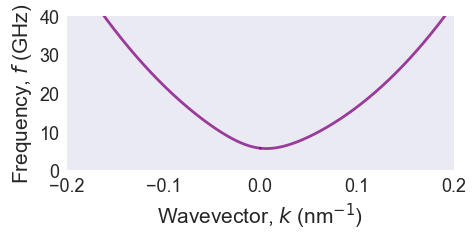

In [14]:
# Set range for wavevectors (not beyond first Brillouin zone at $\pi/lattice_constant$
kmax = 0.8 * 1e9
ks = np.linspace(1e-10, kmax, int(round(system_prop.numcells[0] / 2)))
ks_n = np.linspace(-kmax, 1e-10, int(round(system_prop.numcells[0] / 2)))

# Most generalised dispersion relation
oms_g_ua = cdr.Omega_generalised_with_ua(system_prop,
                                         bias_field[2], sat_mag, exchange_stiffness, D_ij,
                                         ks, system_prop.cell[0],
                                         K_1, K_2, aniso_axis,
                                         gamma0 / (2 * np.pi * 1e9), p=1,
                                         has_demag=1, has_dmi=1, has_aniso=1)

oms_g_ua_n = cdr.Omega_generalised_with_ua(system_prop,
                                           bias_field[2], sat_mag, exchange_stiffness, D_ij,
                                           ks_n, system_prop.cell[0],
                                           K_1, K_2, aniso_axis,
                                           gamma0 / (2 * np.pi * 1e9), p=1,
                                           has_demag=1, has_dmi=1, has_aniso=1)

# Plot figure
fig1, ax1 = plt.subplots(figsize=(5, 2), nrows=1, ncols=1)

ax1.plot(ks * 1e-9, oms_g_ua, lw=2, ls='-', color='purple', alpha=0.75,
        label='Theory', zorder=1.99)
ax1.plot(ks_n * 1e-9, oms_g_ua_n, lw=2, ls='-', alpha=0.75, color='purple',
        zorder=1.99)

ax1.set(xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Frequency, $f$ (GHz)',
       xlim=(-0.2, 0.2), ylim=(0, 40)
       )

#ax1.legend(labelcolor='black')

plt.show()

## Regions

In [15]:
%%capture
system_region = csp.MyRegions(system.name + "_regions");

system_region.main(p1=system_prop.p1, p2=system_prop.p2,
                   dims=('x', 'y', 'z'), units=system_prop.units);

In [16]:
%%capture
system_subregions = csp.MyRegions(system.name + "_subregions")

system_subregions.fixedLhs(p1=system_region.main.pmin,
                           p2=(system_prop.cell[0], system_prop.width, system_prop.thickness), 
                           dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingLhs(p1=csp.add_tuples(system_subregions.fixedLhs.pmax,
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.fixedLhs.pmax, system_prop.cell,
                                       mult=600, dims='x'),
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeLhs(p1=csp.add_tuples(system_subregions.dampingLhs.pmax,
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.dampingLhs.pmax, system_prop.cell,
                                       mult=3290, dims='x'),  # 3225
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.gradientLhs(p1=csp.add_tuples(system_subregions.freeLhs.pmax,
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeLhs.pmax, system_prop.cell,
                                       mult=400, dims='x'),  # 3225
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.driven(p1=csp.add_tuples(system_subregions.gradientLhs.pmax,
                                       dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.gradientLhs.pmax, system_prop.cell,
                                           mult=120, dims='x'),
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.gradientRhs(p1=csp.add_tuples(system_subregions.driven.pmax,
                                                dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.driven.pmax, system_prop.cell,
                                           mult=400, dims='x'),  # 3225
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.freeRhs(p1=csp.add_tuples(system_subregions.gradientRhs.pmax,
                                            dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.gradientRhs.pmax, system_prop.cell,
                                           mult=3290, dims='x'),
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.dampingRhs(p1=csp.add_tuples(system_subregions.freeRhs.pmax,
                                               dims='x', base=system_prop.p1),
                         p2=csp.add_tuples(system_subregions.freeRhs.pmax, system_prop.cell,
                                           mult=600, dims='x'),
                         dims=('x', 'y', 'z'), units=system_prop.units)

system_subregions.fixedRhs(p1=csp.add_tuples(system_subregions.dampingRhs.pmax,
                                             dims='x', base=system_prop.p1),
                           p2=system_region.main.pmax,
                           dims=('x', 'y', 'z'), units=system_prop.units)

In [17]:
%%capture
system_region.mesh = df.Mesh(region=system_region.main.region,
                              cell=system_prop.cell,
                              #bc='x',
                              subregions=system_subregions.subregions)

system_region.mesh.mpl.subregions(figsize=(8, 6),
                                  multiplier=1e-9,box_aspect=(50, 5, 1), show_region=True)

### Energy equations

In [18]:
# Define the smoothing function
def smoothingFunction(pos, start_pos, end_pos, h0):
    # Linearly interpolate the field strength between h0 and 0
    scaling_factor = (1 - (pos - start_pos) / (end_pos - start_pos))
    return (h0[0] * scaling_factor, h0[1] * scaling_factor, h0[2] * scaling_factor)

def h0_func(pos):
    x = pos[0]  # Use only the x-coordinate

    if pos in system_subregions.driven.region:
        return h0

    # Left gradient region
    if pos in system_subregions.gradientLhs.region:
        start_pos = system_subregions.gradientLhs.region.pmax[0]
        end_pos = system_subregions.gradientLhs.region.pmin[0]
        return (0, 0, 0)  # smoothingFunction(x, start_pos, end_pos, h0)

    # Right gradient region
    if pos in system_subregions.gradientRhs.region:
        start_pos = system_subregions.gradientRhs.region.pmin[0]
        end_pos = system_subregions.gradientRhs.region.pmax[0]
        return (0, 0, 0)  # smoothingFunction(x, start_pos, end_pos, h0)

    return (0, 0, 0)  # No drive outside these regions

In [19]:
dmi_regions = {'fixedLhs': 0.0, 'dampingLhs': 0.0,
               'freeLhs': 0.0, 'freeLhs:gradientLhs': 0.0,
               'gradientLhs': 0, 'gradientLhs:driven': (D_ij),
               'driven': D_ij,
               'driven:gradientRhs': (D_ij), 'gradientRhs': 0,
               'freeLhs:gradientRhs': 0.0, 'freeRhs': 0.0,
               'dampingRhs': 0.0, 'fixedRhs': 0.0}

In [20]:
h0_field = df.Field(mesh=system_region.mesh, nvdim=3, value=h0_func)

In [21]:
system.energy = (mm.Exchange(A=exchange_stiffness) 
                 + mm.Zeeman(H=bias_field, name='static')
                 + mm.DMI(D=dmi_regions, crystalclass='Cnv_y')
                 #+ mm.UniaxialAnisotropy(K1=K_1, K2=K_2, u=aniso_axis)
                 + mm.Demag()#asymptotic_radius=32)
                 )

In [22]:
system.energy

Exchange(A=1.3e-11) + Zeeman(H=(0.0, 0.0, 119366.2073189215)) + DMI(D={'fixedLhs': 0.0, 'dampingLhs': 0.0, 'freeLhs': 0.0, 'freeLhs:gradientLhs': 0.0, 'gradientLhs': 0, 'gradientLhs:driven': 0.0004, 'driven': 0.0004, 'driven:gradientRhs': 0.0004, 'gradientRhs': 0, 'freeLhs:gradientRhs': 0.0, 'freeRhs': 0.0, 'dampingRhs': 0.0, 'fixedRhs': 0.0}, crystalclass='Cnv_y') + Demag()

### Dynamics

In [23]:
def alpha_abc_func(pos):
    # current positions
    x, y, z = pos  # spatial coordinates in base units
    xn, yn, zn = (coord * 1e9 for coord in pos)  # cell coordinates as indexes

    # Handle driving region
    if xn in system_subregions.driven.region:
        return alpha_driven

    def damping_interfacial(x_left, x_right, alpha_left, alpha_right):
        xmin_interfacial = int(x_left / system_prop.cell[0])
        xmax_interfacial = int(x_right / system_prop.cell[0])
        num_cells = xmax_interfacial - xmin_interfacial

        alpha_linspace = np.linspace(alpha_left, alpha_right, num_cells)

        pos_indexed = np.arange(xmin_interfacial, xmax_interfacial,
                                int(system_prop.cell[0] / 1e-9), dtype=int)

        mapping_indices_damping = dict(zip(pos_indexed, alpha_linspace))

        if xn in mapping_indices_damping:
            return mapping_indices_damping[xn]
        else:
            exit(1)

    # Handle interfacial 'gradient' regions
    if xn in system_subregions.gradientLhs.region:
        return damping_interfacial(system_subregions.gradientLhs.pmin[0],
                                   system_subregions.gradientLhs.pmax[0],
                                   alpha_bulk, alpha_driven)
    elif xn in system_subregions.gradientRhs.region:
        return damping_interfacial(system_subregions.gradientRhs.pmin[0],
                                   system_subregions.gradientRhs.pmax[0],
                                   alpha_driven, alpha_bulk)

    #elif xn in system_subregions.gradientLhs.region or xn in system_subregions.gradientRhs.region:
    #   return 0.01

    # Otherwise, site is in Bulk, or fixed region
    # min and max cell coordinates of system
    xmin, ymin, zmin = (p1_val * 1e9 for p1_val in system_prop.p1)
    xmax, ymax, zmax = (p2_val * 1e9 for p2_val in system_prop.p2)
    
    # A.B.C. widths
    derived_widths_lhs = [int(val / system_subregions.dampingLhs.region.multiplier) for val in system_subregions.dampingLhs.region.edges]

    widths = {'x': derived_widths_lhs[0], 'y': derived_widths_lhs[1], 'z': derived_widths_lhs[2]}

    # left (a) and right (b) bounds of the A.B.C. region
    xa, ya, za = xmin + widths['x'], ymin + widths['y'], zmin + widths['z']
    xb, yb, zb = xmax - widths['x'], ymax - widths['y'], zmax - widths['z']
    
    # Scales damping between [alpha, 1.0]
    if xn < xa:
        return np.exp( ((xmin - xn) * np.log(alpha_bulk)) / (xmin - xa) )
    elif xn > xb:
        return np.exp( ((xmax - xn) * np.log(alpha_bulk)) / (xmax - xb) )

    return alpha_bulk

In [24]:
alpha_field = df.Field(mesh=system_region.mesh, nvdim=1, value=alpha_abc_func)

In [25]:
# If value is provided here then one MUST use gamma_G (not gamma_LL) when defining subsequent evolvers
system.dynamics = mm.Precession(gamma0=gamma0*mm.consts.mu0) + mm.Damping(alpha=alpha_field)
system.dynamics

Precession(gamma0=222658.2752885759) + Damping(alpha=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[8.804e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[8804, 1, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[1e-09, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[1e-09, 0.0, 0.0], pmax=[6.01e-07, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[6.01e-07, 0.0, 0.0], pmax=[3.8910000000000005e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`gradientLhs`(pmin=[3.8910000000000005e-06, 0.0, 0.0], pmax=[4.291000000000001e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`driven`(pmin=[4.291000000000001e-06, 0.0, 0.0], pmax=[4.411000000000001e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`gradientRhs`(pmin=[4.411000000000001e-06, 0.0, 0.0], pmax=[4.811000000000001e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'

In [26]:
def m_init_func(pos):
    if pos in system_subregions.fixedLhs.region or pos in system_subregions.fixedRhs.region:
        return (0.0, 0.0, 1.0)
    else:
        return (0.0, 0.0, 1.0)

In [27]:
system.m = df.Field(mesh=system_region.mesh, nvdim=3, value=m_init_func, norm=sat_mag)

### Relaxation

In [28]:
min_evolver = oc.CGEvolver(method='Polak-Ribiere',
                           fixed_spins=['fixedLhs', 'fixedRhs'])

minD = oc.MinDriver(evolver=min_evolver,
                    stopping_mxHxm=0.1)

In [29]:
minD.drive(system, dirname=data_output, 
           fixed_subregions=['fixedLhs', 'fixedRhs'],
           verbose=2)

Running OOMMF (TclOOMMFRunner)[2025/04/15 13:29]... (1.1 s)


In [30]:
%%capture
cip.default_three_pane(system=system, system_prop=system_prop, system_region=system_region,
                       figs_output_dir=figs_output, drive_number=system.drive_number,
                       fig_name='after_relaxation', has_schematic=False,
                       #scalar_resample_shape=[256, 3], vector_resample_shape=[16, 3]
                       )

### Time-dependent field

In [31]:
system.energy += mm.Zeeman(H=h0_field, name='pump', func='sin',f=driving_freq, t0=0*h)

In [32]:
system.energy

Exchange(A=1.3e-11) + Zeeman(H=(0.0, 0.0, 119366.2073189215)) + DMI(D={'fixedLhs': 0.0, 'dampingLhs': 0.0, 'freeLhs': 0.0, 'freeLhs:gradientLhs': 0.0, 'gradientLhs': 0, 'gradientLhs:driven': 0.0004, 'driven': 0.0004, 'driven:gradientRhs': 0.0004, 'gradientRhs': 0, 'freeLhs:gradientRhs': 0.0, 'freeRhs': 0.0, 'dampingRhs': 0.0, 'fixedRhs': 0.0}, crystalclass='Cnv_y') + Demag() + Zeeman(H=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[8.804e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[8804, 1, 1], subregions: (Region`fixedLhs`(pmin=[0.0, 0.0, 0.0], pmax=[1e-09, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`dampingLhs`(pmin=[1e-09, 0.0, 0.0], pmax=[6.01e-07, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`freeLhs`(pmin=[6.01e-07, 0.0, 0.0], pmax=[3.8910000000000005e-06, 1e-09, 1.2e-08], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`gradientLhs`(pmin=[3.8910000000000005e-06, 0.0, 0.0], pmax=[4.291000000000001e-06,

In [33]:
sim_evolver = oc.RungeKuttaEvolver(method='rkf54',
                                   #alpha=alpha,
                                   #gamma_G=gamma0*mm.consts.mu0,
                                   fixed_spins=['fixedLhs', 'fixedRhs'],
                                   do_precess=1,
                                   allow_signed_gamma=0,
                                   )

td = oc.TimeDriver(evolver=sim_evolver)

In [34]:
td.drive(system, dirname=data_output, t=tmax, n=num_steps,
         fixed_subregions=['fixedLhs', 'fixedRhs'],
         n_threads=10,
         verbose=2,
         **sim_params)

Running OOMMF (TclOOMMFRunner):   0%|          | 0/400 files written [00:00]

Running OOMMF (TclOOMMFRunner)[2025/04/15 13:30] took 322.4 s


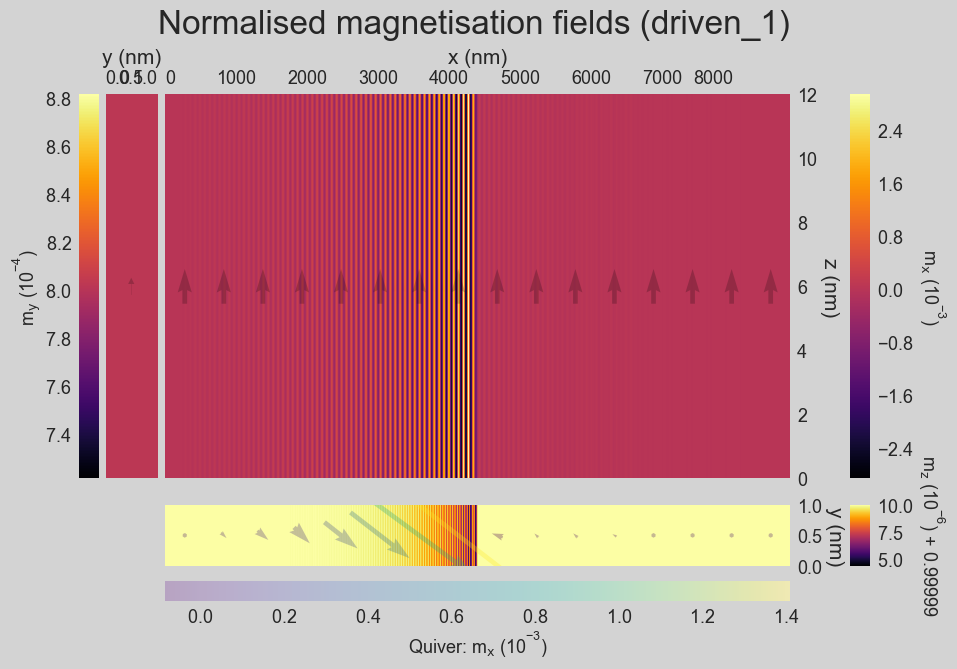

In [35]:
cip.default_three_pane(system, system_prop, system_region,
                       figs_output, system.drive_number - 1,
                       f'driven_{system.drive_number - 1}', has_schematic=False)

In [36]:
# Cell which acts as a breakpoint; 0/0 intentionally produces an error. Alternative is to utilise the 'raise' keyword
#raise ValueError('Breakpoint')

### Import data for dispersion relation

In [37]:
m_all_data = md.Drive(name=system.name, dirname=data_output, number=system.drive_number - 1, use_cache=True)
data_m0 = m_all_data.m0.to_xarray().values

m_pos = [int(round(system_prop.width * 0.5 / system_prop.cell[1], 0)),
         int(round(system_prop.thickness * 0.5 / system_prop.cell[2], 0))]

data_mx0 = data_m0[:, m_pos[0], m_pos[1], 0] / sat_mag
data_my0 = data_m0[:, m_pos[0], m_pos[1], 1] / sat_mag
data_mz0 = data_m0[:, m_pos[0], m_pos[1], 2] / sat_mag

data_mx = np.zeros((m_all_data.n, int(system_prop.numcells[0])))
data_my = np.zeros((m_all_data.n, int(system_prop.numcells[0])))
data_mz = np.zeros((m_all_data.n, int(system_prop.numcells[0])))

m_data = m_all_data.to_xarray()

for i, _ in enumerate(m_data):
    data_mx[i] = (m_data[i, :, m_pos[0], m_pos[1], 0].values / sat_mag) - data_mx0
    data_my[i] = (m_data[i, :, m_pos[0], m_pos[1], 1].values / sat_mag) - data_my0
    data_mz[i] = (m_data[i, :, m_pos[0], m_pos[1], 2].values / sat_mag) - data_mz0

In [38]:
%%capture
# Prepare the meshgrid for 3D plot
x = np.linspace(0, system_prop.length, data_mx.shape[1])
z = np.linspace(0, system_prop.thickness, data_mx.shape[0])
X, Z = np.meshgrid(x, z)
Y = np.ones_like(X) * system_prop.width / 2  # y is fixed slice

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, 
                       data_mx, 
                       cmap='viridis')  # data_mx as example

# Add color bar to indicate the scale
fig.colorbar(surf)

# Customize the view angle
ax.view_init(elev=30, azim=120)

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Width')
ax.set_zlabel('Magnetization')

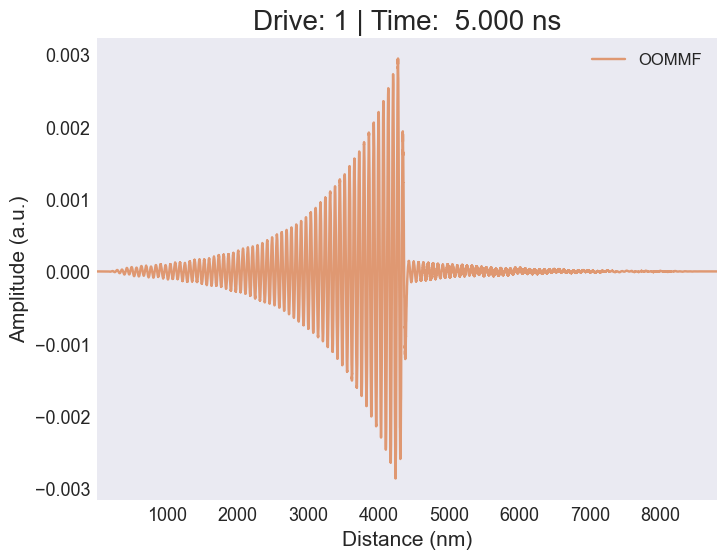

In [48]:
time_index = 400
plt.plot(np.arange(0, system_prop.numcells[0] * (system_prop.cell[0] / 1e-9), system_prop.cell[0] / 1e-9),
         data_mx[time_index-1, :], alpha=0.8, color='C1', label='OOMMF')
#my_pos_times, my_pos_vals = np.loadtxt('/Users/cameronmceleney/pCloud Drive/test/data_se.txt')
#plt.plot(my_pos_times, my_pos_vals[::-1], zorder=0.9, label='C++', color='C4')
plt.gca().set(title=f'Drive: {m_all_data.info['drive_number']} | Time: {time_index * (tmax/num_steps) / 1e-9: .3f} ns', xlim=(1, system_prop.length * 1e9),
              xlabel='Distance (nm)', ylabel='Amplitude (a.u.)')
plt.legend()
plt.savefig(figs_output + '/drive-' + str(m_all_data.number) + f'_pos_{int(time_index/1e3)}ns.png', dpi=300, bbox_inches='tight')
plt.show()

In [40]:
 # Cell which acts as a breakpoint; 0/0 intentionally produces an error. Alternative is to utilise the 'raise' keyword
#raise ValueError('Breakpoint')

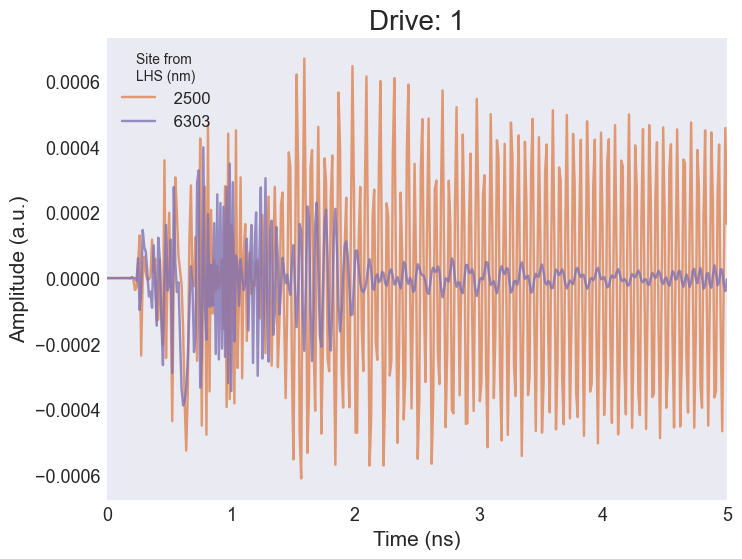

In [49]:
pos_index_1 = 3600
pos_index_2 = system_prop.numcells[0] - 1 - pos_index_1
plt.plot(np.linspace(0, tmax-h, num_steps)*1e9, data_mx[:, pos_index_1], alpha=0.8, color='C1', label=f'{pos_index_1: .0f}')
plt.plot(np.linspace(0, tmax-h, num_steps)*1e9, data_mx[:, pos_index_2], alpha=0.8, color='C4', label=f'{pos_index_2: .0f}')

#my_times, my_vals = np.loadtxt('/Users/cameronmceleney/pCloud Drive/test/data.txt')
#plt.plot(my_times[:], my_vals, zorder=0.9, color='C4', label='C++')
plt.gca().set(title=f'Drive: {m_all_data.number}', xlim=(0, 5),
              xlabel='Time (ns)', ylabel='Amplitude (a.u.)')
plt.legend(title='Site from\nLHS (nm)')

plt.savefig(figs_output + '/drive-' + str(m_all_data.number) + f'_time_{pos_index_1}nm.png', dpi=300, bbox_inches='tight')

### Dispersion relation

In [42]:
def Omega_generalised_with_ua(system_prop, H0, Ms, A, D, k, d, K1, K2, aniso_axis, gamma, p=1,
                              has_demag=1, has_dmi=1, has_aniso=1):
    J = 2 * A / (mm.consts.mu0 * Ms)
    DM = -2 * D / (mm.consts.mu0 * Ms)

    demag_factors = cpe.calculate_demag_factor_uniform_prism(system_prop.length - 2 * d,
                                                             system_prop.width,
                                                             system_prop.thickness)
    # print(demag_factors)

    #om = np.sqrt((H0 + J * (k ** 2) + has_demag * Ms * (demag_factors['N_x'] - demag_factors['N_z']))
    #             * (H0 + J * (k ** 2) + has_aniso * ((4 * (aniso_axis[2] ** 2)) / (Ms * mm.consts.mu0)
    #                                                 * (1 * K1 + 2 * K2 * (aniso_axis[2] ** 2)))
    #                + has_demag * Ms * (demag_factors['N_y'] - demag_factors['N_z'])
    #                )
    #             + has_aniso * (4 * (aniso_axis[2] ** 4)) / (Ms ** 2 * mm.consts.mu0 ** 2)
    #             * (4 * (K1**2) + 4 * K1 * K2 * (aniso_axis[2] ** 2) + 4 * (K2 ** 2) * (aniso_axis[2] ** 4))
    #             )
    om = np.sqrt((H0
                  + J * (k ** 2)
                  + has_aniso * ((2 * (aniso_axis[2] ** 2)) / (Ms * mm.consts.mu0) * (1 * K1 + 2 * K2 * (aniso_axis[2] ** 2)))
                  + has_demag * Ms * (demag_factors['N_x'] - demag_factors['N_z']))
                 * (H0
                    + J * (k ** 2)
                    + has_aniso * ((2 * (aniso_axis[2] ** 2)) / (Ms * mm.consts.mu0) * (1 * K1 + 2 * K2 * (aniso_axis[2] ** 2)))
                    + has_demag * Ms * (demag_factors['N_y'] - demag_factors['N_z'])
                )
             )

    om += has_dmi * p * DM * k

    # the mu0 factor shown in the paper is not necessary if we use gamma
    # in Hz / (A / m)
    om *= (gamma * mm.consts.mu0)

    return om

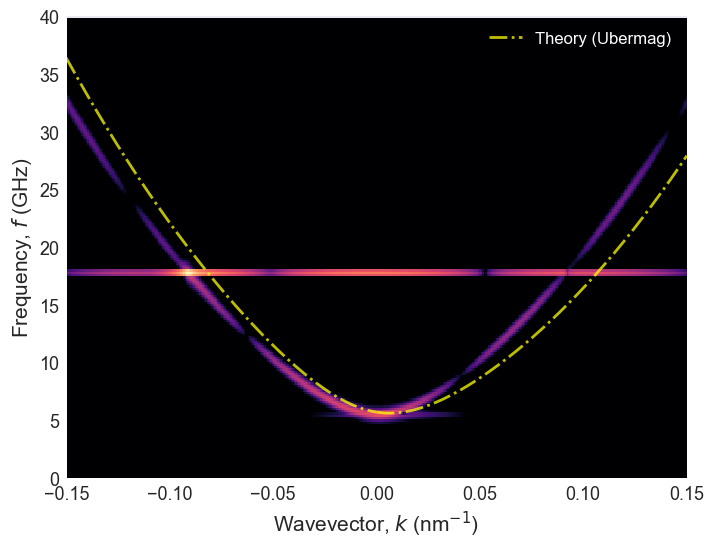

In [43]:
kmax = 0.8 * 1e9
ks = np.linspace(1e-10, kmax, int(round(system_prop.numcells[0] / 2)))
ks_n = np.linspace(-kmax, 1e-10, int(round(system_prop.numcells[0] / 2)))

# Moon Eq. (12)
#oms = cdr.Omega_Moon(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_n = cdr.Omega_Moon(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#
## Moon Eq. (14)
#oms_l = cdr.Omega_Moon_large_k(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_l_n = cdr.Omega_Moon_large_k(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#
## Moon Eq. (16)
#oms_s = cdr.Omega_Moon_small_k(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_s_n = cdr.Omega_Moon_small_k(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#
## Custom dispersion relation
#oms_c = cdr.Omega_Moon_custom(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)
#oms_c_n = cdr.Omega_Moon_custom(bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, demag=1, has_dmi=1)

# Custom dispersion relation
oms_g = cdr.Omega_generalised_with_ua(system_prop,
                                         bias_field[2], sat_mag, exchange_stiffness, D_ij,
                                         ks, system_prop.cell[0],
                                         K_1, K_2, aniso_axis,
                                         gamma0 / (2 * np.pi * 1e9), p=1,
                                         has_demag=1, has_dmi=1, has_aniso=1)
oms_g_n = cdr.Omega_generalised_with_ua(system_prop,
                                           bias_field[2], sat_mag, exchange_stiffness, D_ij,
                                           ks_n, system_prop.cell[0],
                                           K_1, K_2, aniso_axis,
                                           gamma0 / (2 * np.pi * 1e9), p=1,
                                           has_demag=1, has_dmi=1, has_aniso=1)

times = m_data['t'].values
x = m_data['x'].values

# Create Hanning windows
times_filter = np.hanning(len(times))
x_filter = np.hanning(len(x))

# Apply the Hanning window to the data
window = np.outer(times_filter, x_filter)
data_mx_windowed = data_mx * window

fft_data = np.fft.fft2(data_mx_windowed)
fft_data = abs(np.fft.fftshift(fft_data))
log_fft_data = np.log10(fft_data**2)

freqs = np.fft.fftfreq(n=len(times), d=(times[1] - times[0])) * 1e-9
freqs = np.fft.fftshift(freqs)

k = np.fft.fftfreq(n=len(x), d=(x[1] - x[0])) * 1e-9
k = np.fft.fftshift(k) * 2 * np.pi

fig5, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(log_fft_data, extent=[k[0], k[-1], freqs[0], freqs[-1]], 
          vmin=log_fft_data.min() / 10, vmax=log_fft_data.max(),
          aspect='auto', interpolation='none',
          cmap='magma')

#ax.plot(ks * 1e-9, oms, lw=2, ls='--', color='white', alpha=0.5, label='Theory (Moon)')
#ax.plot(ks_n * 1e-9, oms_n, lw=2, ls='--', alpha=0.5, color='white')

#ax.plot(ks * 1e-9, oms_l, lw=2, ls='-.', color='lightgreen', alpha=0.5, label='Theory (Large k)')
#ax.plot(ks_n * 1e-9, oms_l_n, lw=2, ls='-.', alpha=0.5, color='lightgreen')

#ax.plot(ks * 1e-9, oms_s, lw=2, ls='-.', color='orange', alpha=1, label='Theory (Small k)')
#ax.plot(ks_n * 1e-9, oms_s_n, lw=2, ls='-.', alpha=1, color='orange')

#ax.plot(ks * 1e-9, oms_c, lw=2, ls=':', color='lightblue', alpha=1, label='Theory (Custom)')
#ax.plot(ks_n * 1e-9, oms_c_n, lw=2, ls='-.', alpha=1, color='lightblue')

ax.plot(ks * 1e-9, oms_g, lw=2, ls='-.', color='yellow', alpha=0.75, label='Theory (Ubermag)')
ax.plot(ks_n * 1e-9, oms_g_n, lw=2, ls='-.', alpha=0.75, color='yellow')

# Load the arrays from the .npz file
#data = np.load('/Users/cameronmceleney/Data/2024-07-29/data.npz')
#ksc = data['ks']
#ksc_n = data['ks_n']
#omsc_g = data['oms_g']
#omsc_g_n = data['oms_g_n']

#ax.plot(ksc * 1e-9, omsc_g, ls='-.', color='purple', alpha=0.75, label='Theory (C++)')
#ax.plot(ksc_n * 1e-9, omsc_g_n, ls='-.', alpha=0.75, color='purple')

ax.set(xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Frequency, $f$ (GHz)',
       xlim=(-0.15, 0.15),
       ylim=(0, 40)
       )
       

#handles, labels = ax.get_legend_handles_labels()
#blacks = matplotlib.patches.Patch(color='purple', label='OOMMf')
#ax.legend(handles=[handles[0], blacks])
ax.legend(labelcolor='white')
plt.savefig(figs_output + '/drive-' + str(system.drive_number - 1) + '_dispersion_relation.png', dpi=300, bbox_inches='tight')


IndexError: index 999 is out of bounds for axis 0 with size 400

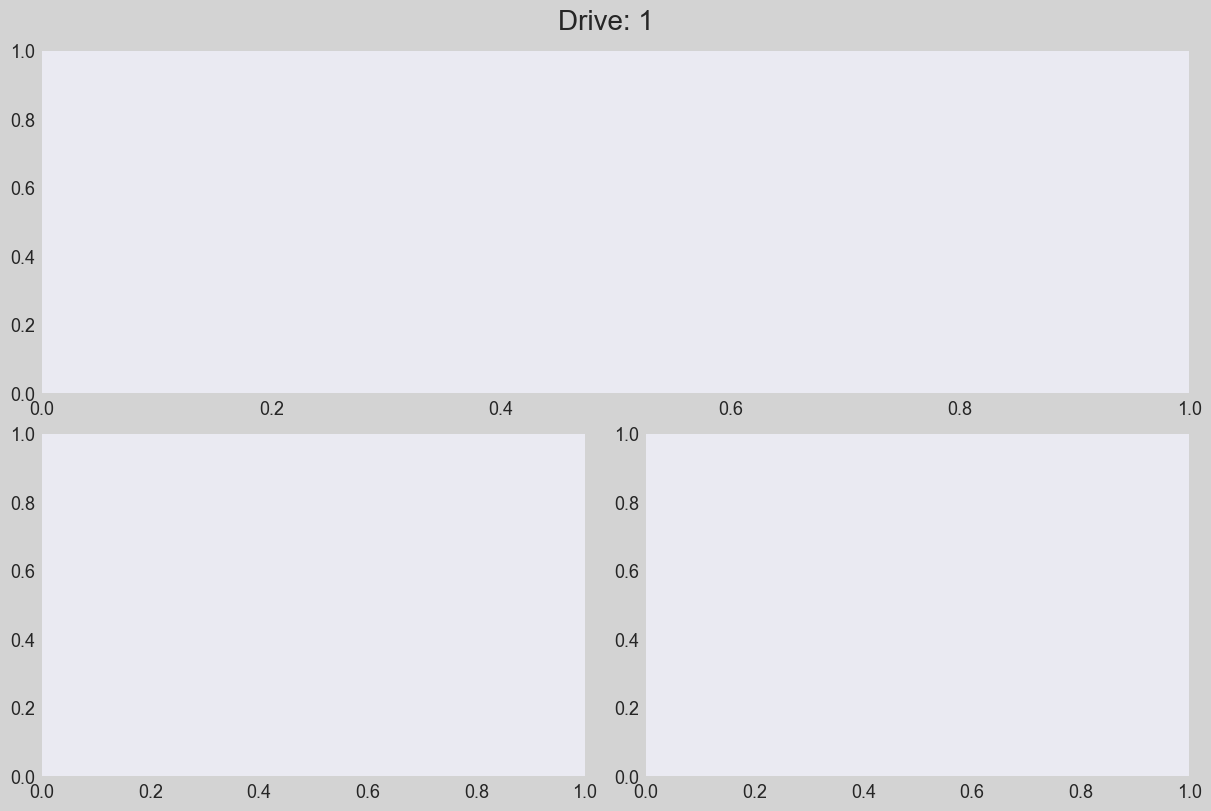

In [44]:
fig_fft, fig_fft_axes = plt.subplot_mosaic(mosaic=[['k-space', 'k-space'],
                                          ['freq-space-lhs', 'freq-space-rhs']],
                                  figsize=(12, 8),
                                  gridspec_kw={'width_ratios': (1, 1),
                                               'height_ratios': (1, 1),
                                               'wspace': 0.0,
                                               'hspace': 0.0},
                                  layout='constrained',
                                  facecolor='lightgrey'
                                  )

fig_fft.suptitle(f'Drive: {m_all_data.number}', fontsize=20)

for i in range(1, int(tmax * 1e9)+1):
    fig_fft_axes['k-space'].plot(k, log_fft_data[i * 1000 - 1, :], label=f'{i}')
fig_fft_axes['k-space'].set(title=f'FFT across full spin chain',
              xlabel='Wavevector',
              ylabel='Amplitude (log)',
              xlim=[-0.2, 0.2])
fig_fft_axes['k-space'].legend(title='Sim. time (ns)', ncols=2)

for fft_pos_index in range(300, 2101, 300):
     fig_fft_axes['freq-space-lhs'].plot(freqs, log_fft_data[:, fft_pos_index], #label=f'{fft_pos_index * system_prop.cell[0] * 1e9 * 2: .0f}')
                                         label=f'{fft_pos_index * system_prop.cell[0] * 1e9: .0f}')
fig_fft_axes['freq-space-lhs'].set(title=f'FFT at single site',
              xlabel='Frequency (GHz)',
              ylabel='Amplitude (log)',
              xlim=[0, 40])
fig_fft_axes['freq-space-lhs'].axvline(x=driving_freq*1e-9, color='black', zorder=1.1, alpha=0.75,
                                       label=f'Driving freq: {driving_freq*1e-9:.2f} GHz')

fig_fft_axes['freq-space-lhs'].legend(title='Site (nm)', ncols=2, loc='upper right')


for fft_pos_index in range(4100, 2299, -300):
    fig_fft_axes['freq-space-rhs'].plot(freqs, log_fft_data[:, fft_pos_index], #label=f'{fft_pos_index * system_prop.cell[0] * 1e9 * 2: .0f}')
                                        label=f'{fft_pos_index * system_prop.cell[0] * 1e9: .0f}')
fig_fft_axes['freq-space-rhs'].set(title=f'FFT at single site',
              xlabel='Frequency (GHz)',
              ylabel='Amplitude (log)',
              xlim=[0, 40])
fig_fft_axes['freq-space-rhs'].axvline(x=driving_freq*1e-9, color='black', zorder=1.1, alpha=0.75,
                                        label=f'Driving freq: {driving_freq*1e-9:.2f} GHz')
fig_fft_axes['freq-space-rhs'].legend(title='Site (nm)', ncols=2, loc='upper right')

plt.savefig(figs_output + '/drive-' + str(m_all_data.number) + '_fft_mosaic.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), nrows=1, ncols=1)
#for fft_pos_index in range(300, 2101, 300):
for fft_pos_index in [4402]:
     ax.plot(k, log_fft_data[time_index-1, :], #label=f'{fft_pos_index * system_prop.cell[0] * 1e9 * 2: .0f}')
                                         label=f'left')
ax.set(title=f'FFT at single site',
              xlabel='Wavevector (nm^-1)',
              ylabel='Amplitude (log)',
       )



ax.legend(title='Site (nm)', ncols=1)

In [ ]:
import scipy as sp
import numpy as np

def _fft_data(input_data, spatial_spacing: bool | float = None, fft_window: str = False):
    """
    Computes the discrete Fourier transform (DFT) of a given 1-D signal using FFT algorithms.

    Regarding the returned `dft_samples`, if the `input_data` contains:
        - spatial information then dft_samples will represent 'wavevectors', and be in units of inverse-length.
        - temporal information then dft_samples will represent 'frequencies', and be in units of Hz.

    Regarding the returned `discrete_fourier_transform`, it will contain the magnitudes of the DFT results. It will
    be the absolute value of the DFT results; caution if the phase information is needed for subsequent analysis.

    :param input_data: Magnitudes of a magnetic moment components for a given axis.
    :param spatial_spacing: The lattice constant for the system for spatial data.
    :param fft_window: Apply a window to the data before taking the FFT; default is a Hann window.

    :return: A tuple containing the sample frequencies [0] and DFT results [1].
    """

    # Pad the data to greatly improve efficiency of the FFT computation
    n_total = input_data.size

    n_total_padded = sp.fft.next_fast_len(n_total)

    # Find the bin size
    if spatial_spacing is None:
        # For temporal: divide the simulated time into equally sized segments based upon the number of data-points.
        sample_spacing = (tmax / (num_steps - 1))
    else:
        # For spatial: division of lattice is already known with the lattice constant
        sample_spacing = spatial_spacing

    # Data for DFT (create copy to avoid modifying original data)
    data_to_process = input_data

    # Select a window for the FFT.
    if fft_window is not None:
        if isinstance(fft_window, str):
            # For valid windows, see https://docs.scipy.org/doc/scipy/reference/signal.windows.html
            if fft_window == 'bb':
                window = 1
            else:
                window_func = getattr(sp.signal.windows, fft_window, "hann")
                window = window_func(n_total)
        elif callable(fft_window):
            # Incase the user wants a custom window function
            window = sp.signal.fft_window(n_total)
        else:
            # Default case
            window = sp.signal.windows.hann(n_total)

        # *= doesn't work here for some reason without breaking subplots
        data_to_process = data_to_process * window

    # Perform the FFT
    discrete_fourier_transform = sp.fft.fft(data_to_process, n_total_padded)

    # Samples from the DFT.
    dft_samples = sp.fft.fftfreq(n_total_padded, sample_spacing)

    # Always skip the DC component at y[0] as I don't need the signal's mean value
    if n_total_padded % 2 == 0:
        # For N even, the elements `y = [1, N / 2 -1]` contain the positive-frequency terms with the final
        # element `y = N / 2` containing the Nyquist frequency
        positive_wavevector_indices = slice(1, n_total_padded // 2)
    else:
        # For N odd, the elements `y = [1, (N - 1) / 2]` contain the positive-frequency terms
        positive_wavevector_indices = slice(1, (n_total_padded + 1) // 2)

    # Only want positive wavevectors and their corresponding fourier transform. Must take absolute value of DFT.
    discrete_fourier_transform = np.abs(discrete_fourier_transform[positive_wavevector_indices])
    dft_samples = dft_samples[positive_wavevector_indices]

    return dft_samples, discrete_fourier_transform

In [ ]:
cdr.Omega_generalised_with_ua(system_prop,
                              bias_field[2], sat_mag, exchange_stiffness, D_ij,
                              0.075e9, system_prop.cell[0],
                              K_1, K_2, aniso_axis,
                              gamma0 / (2 * np.pi * 1e9), p=1,
                              has_demag=1, has_dmi=1, has_aniso=1)

In [ ]:
#k_lines_arr = np.array([ 0.0517, -0.0334,  0.0736, -0.0522,  0.0978, -0.0734,  0.1053,
#       -0.0802,  0.1261, -0.0993,  0.1317, -0.1046,  0.1554, -0.1271,
#        0.1807, -0.1516,  0.1857, -0.1564,  0.2099, -0.1802,  0.2331,
#       -0.2031,  0.2404, -0.2103,])
#k_lines_arr_bal = np.array([
#    0.06400, -0.04390, 0.08540, -0.06240, 0.12120, -0.09480, 0.17430, -0.14530, 0.19580, -0.16640,
#    0.22820, -0.19820,
#])
#k_lines_unknown = np.array([
#    0.04, 0.14
#])

In [ ]:
#k_lines_arr = np.array(
#    [
#    #0.07300, -0.05160,
#	#0.09670, -0.07240,
#	#0.12570, -0.09890,
#	#0.15720,  -0.12880,
#	#0.18070,  -0.15160,
#	#0.20990,  -0.18020,
#	#0.23070,  -0.20070,
#])
#k_lines_arr_bal = np.array([
#                            #0.07295, -0.05160,
#                            #0.10450, -0.07945,
#                            #0.13205, -0.10490,
#                            #0.15720, -0.12880,
#                            #0.18840, -0.15910,
#                            #0.20990, -0.18015,
#                            #0.24035, -0.21025,
#])
#k_lines_unknown = np.array([
#                            0.04000, -0.02350,
#                            0.05960, -0.04020,
#                            0.09010, -0.06650,
#                            0.12120, -0.09480,
#                            0.14060,  -0.11300,
#                            0.17425, -0.14530,
#                            0.19290,  -0.16350,
#                            0.22570,  -0.19570,
#                            ])

In [ ]:
#_lines_arr = np.array([
#                       #0.03075, #-0.01550,
#                       #0.05080, #-0.03270,
#                       #0.07935, #-0.05710,
#                       #0.10450, #-0.07945,
#                       #0.12780, #-0.10095,
#                       #0.15720, #-0.12880,
#                       #0.18065, #-0.15155,
#                       #0.20990, #-0.18015,
#                       #0.23310, #-0.20310,
#                       -0.109, 0.129  # 22.5 GHz
#)
#_lines_arr_bal = np.array([
#                           #0.03075, #-0.01550,
#                           #0.06255, #-0.04265,
#                           #0.08830, #-0.06500,
#                           #0.12120, #-0.09480,
#                           #0.14985, #-0.12180,
#                           #0.17590, #-0.14690,
#                           #0.20015, #-0.17060,
#                           #0.23065, #-0.20065,
#                           #0.25870, #-0.22845,
#                           -0.129, 0.157  # 30GHz
#)
#_lines_unknown = np.array([
#                          # 0.063, -0.04 , # 10
#                          # 0.169, -0.14, # 33
#                          # 0.04,  -0.024, # 7.8
#                          # 0.14,  -0.113, # 25.45
#                           #-0.04, 0.059, # 10
#                           #-0.14, 0.169, # 33
#                           #0.04, -0.024, # 7.8
#                           #0.14, -0.113, # 25.45
#                           #0.18, -0.15, # 36.6
#                           #0.094, -0.74, # 15.4

#                           #0.13, 0.124,#?
#                           #-0.103, 0.158
#                           -0.079, 0.109 , # 17.6
#   0.04


#                                       ])

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 3), nrows=1, ncols=2)
fig.suptitle(f'Drive: {m_all_data.number}', fontsize=20)
freq_loc_1 = pos_index_1
freq_loc_2 = pos_index_2
frequencies1, fourier_transform_freq1 = _fft_data(input_data=data_mx[:, freq_loc_1],
                                    fft_window='bb')
frequencies2, fourier_transform_freq2 = _fft_data(input_data=data_mx[:, freq_loc_2],
                                     fft_window='bb')
frequencies1 *= 1e-9
frequencies2 *= 1e-9

#for fft_pos_index in range(300, 2101, 300):
ax1.plot(frequencies1, fourier_transform_freq1,
       label=f'Site: {freq_loc_1}')

ax1.plot(frequencies2, fourier_transform_freq2,
         label=f'Site: {freq_loc_2}')

ax1.set(title=f'FFT at single site',
              xlabel='Frequency (GHz)',
              ylabel='Amplitude (log)',
              xlim=[0, 40])

ax1.axvline(x=driving_freq*1e-9, color='black', zorder=1.1, alpha=0.75,
            label=f'f_drive: {driving_freq*1e-9:.2f} GHz')


#for fft_pos_index in range(4100, 2299, -300):


ax1.legend(title='Site (nm)', ncols=1)

###
wavevectors1, fourier_transform_k1 = _fft_data(input_data=data_mx[time_index-1, 600:4002],
                                    spatial_spacing=1e-9, fft_window='bb')
wavevectors2, fourier_transform_k2 = _fft_data(input_data=data_mx[time_index-1, 4802:8204],
                                    spatial_spacing=1e-9, fft_window='bb')
wavevectors1 *= 1e-9 * 2 * np.pi
wavevectors2 *= 1e-9 * 2 * np.pi

ax2.plot(wavevectors1, fourier_transform_k1,
           lw=1.5, marker='', markerfacecolor='black', markeredgecolor='black',
           label=f"Left of drive - no dmi")
ax2.plot(wavevectors2, fourier_transform_k2,
           lw=1.5, marker='', markerfacecolor='black', markeredgecolor='black',
           label=f"Right of drive - no dmi")
ax2.set(title="FFT across whole chain",
    xlabel=f"Wavevector, $k$", ylabel=f"Intensity (a.u.)", yscale='log',
       xlim=(0, 0.3))
#ax.axvline(x=9.2)
ax2.legend()

In [ ]:
# Cell which acts as a breakpoint; 0/0 intentionally produces an error. Alternative is to utilise the 'raise' keyword
raise ValueError('Breakpoint')

In [ ]:
kmax = 0.8 * 1e9
ks = np.linspace(1e-10, kmax, int(round(system_prop.numcells[0] / 2)))
ks_n = np.linspace(-kmax, 1e-10, int(round(system_prop.numcells[0] / 2)))


oms_g = Omega_generalised(system_prop, bias_field[2], sat_mag, exchange_stiffness, D_ij, ks, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1)
oms_g_n = Omega_generalised(system_prop, bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n, 1e-9, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1)

# Custom dispersion relation
oms_g_ua = cdr.Omega_generalised_with_ua(system_prop, bias_field[2], sat_mag, exchange_stiffness, D_ij, ks,
                                         1e-9, K_1, K_2, aniso_axis,
                                         gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)
oms_g_ua_n = cdr.Omega_generalised_with_ua(system_prop, bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n,
                                       1e-9, K_1, K_2, aniso_axis, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)

oms_g_n_ua = cdr.Omega_generalised_with_ua(system_prop, bias_field[2], sat_mag, exchange_stiffness, D_ij, ks,
                                     1e-9, 0, 0, aniso_axis, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)
oms_g_n_ua_n = cdr.Omega_generalised_with_ua(system_prop, bias_field[2], sat_mag, exchange_stiffness, D_ij, ks_n,
                                       1e-9, 0, 0, aniso_axis, gamma0 / (2 * np.pi * 1e9), p=1, has_demag=1, has_dmi=1, has_aniso=1)

fig5, ax = plt.subplots(nrows=1, ncols=1)

ax.plot(ks * 1e-9, oms_g_ua, lw=2, ls='-', color='purple', alpha=0.75, 
        label='Theory', zorder=1.99)
ax.plot(ks_n * 1e-9, oms_g_ua_n, lw=2, ls='-', alpha=0.75, color='purple', 
        zorder=1.99)

#ax.plot(ks * 1e-9, oms_g_n_ua, lw=2, ls='--', color='red', alpha=0.75, 
#        label='Theory (New equation - no anisotropy)', zorder=1.98)
#ax.plot(ks_n * 1e-9, oms_g_n_ua_n, lw=2, ls='--', alpha=0.75, color='red', 
#        zorder=1.99)

#ax.plot(ks * 1e-9, oms_g, lw=2, ls='-', color='blue', alpha=0.75, 
#        label='Theory (Old equation - no anisotropy)', zorder=1.97)
#ax.plot(ks_n * 1e-9, oms_g_n, lw=2, ls='-', alpha=0.75, color='blue', 
#        zorder=1.97)

ax.set(xlabel=r'Wavevector, $k$ (nm$^{-1}$)', ylabel=r'Frequency, $f$ (GHz)',
       xlim=(-0.15, 0.15),
       ylim=(0, 40)
       )
ax.legend(labelcolor='black')

plt.show()